# Time Series Forecasting with Machine Learning 

In [15]:
import pandas as pd
import numpy as np 
import seaborn as sns
color_pal = sns.color_palette()
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import xgboost as xgb
from sklearn.metrics import mean_squared_error


In [16]:
df = pd.read_csv('PJME_hourly.csv')

### Set Index as Datetime
df = df.set_index('Datetime')

#Change Datetime Datatype to Datetime
df.index = pd.to_datetime(df.index)

## Data Exploration & Cleaning

In [17]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [18]:
df.shape

(145366, 1)

In [19]:
df.dtypes

PJME_MW    float64
dtype: object

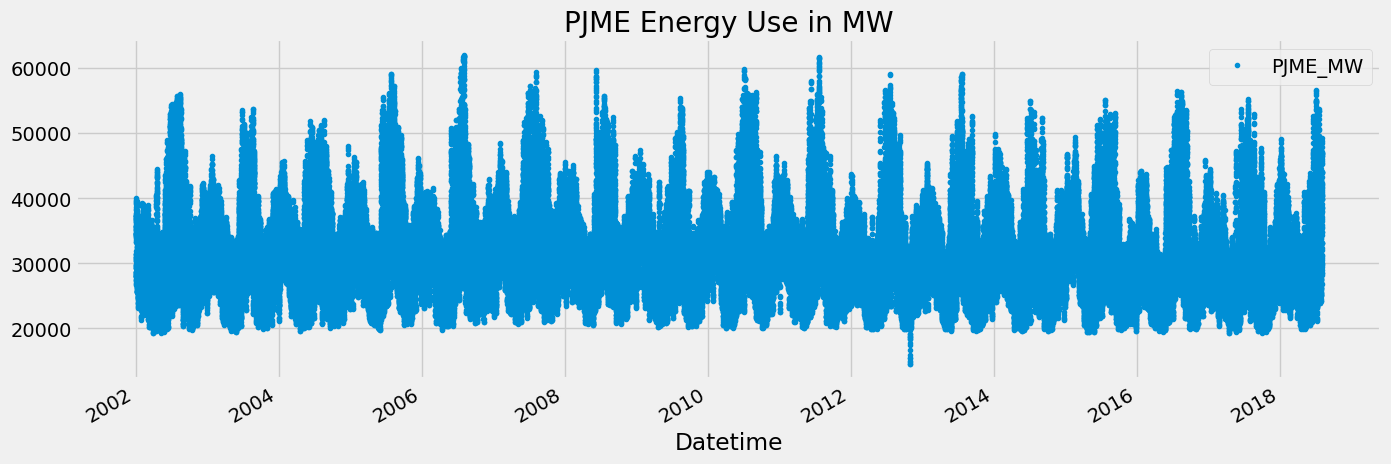

In [20]:
df.plot(style = '.', 
        figsize = (15, 5), 
        color = color_pal[0], 
        title = 'PJME Energy Use in MW');

## Train/Test Split

Our data will be split in 2 sets. prior to Januray 2015 will be in the train set and the data after Janurary 2015 will be in our test set.

In [21]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

### Plot both train and test split 

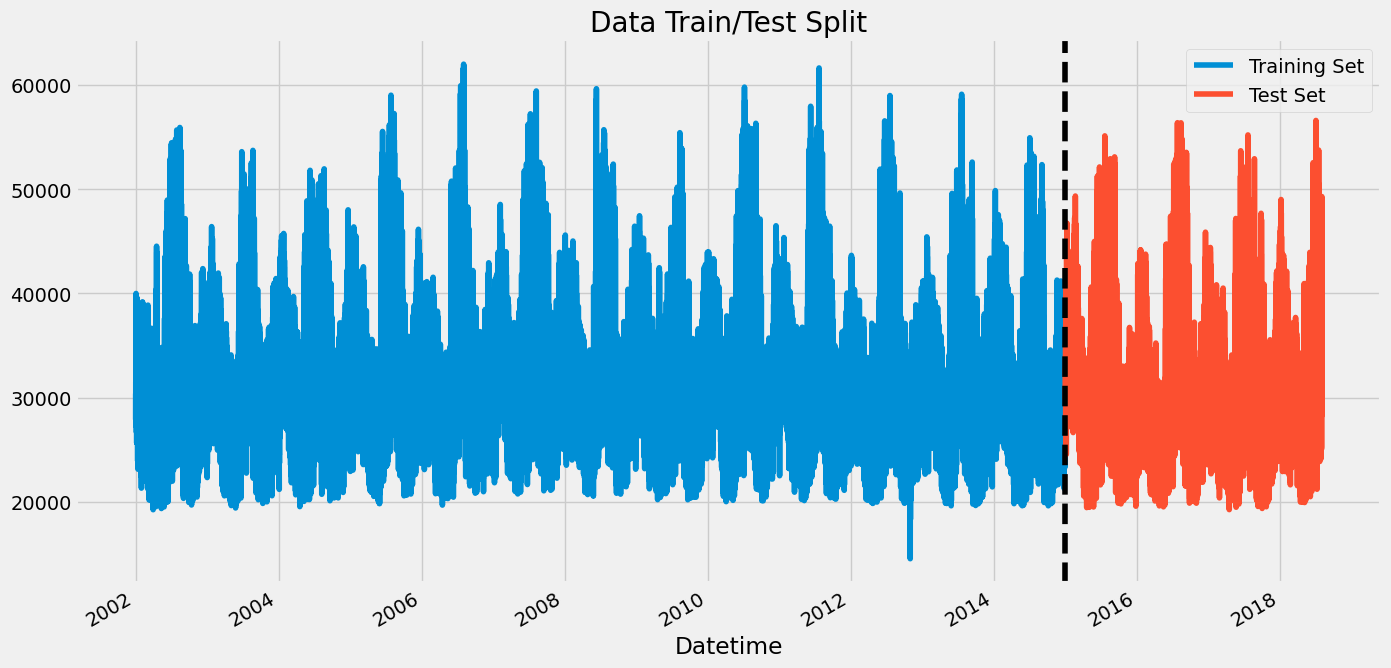

In [22]:
fig, ax = plt.subplots(figsize = (15,8))
train.plot(ax = ax, label= 'Training Set', title = 'Data Train/Test Split')
test.plot(ax = ax, label= 'Test Set')
ax.axvline('01-01-2015', color='black', ls = '--')
ax.legend(['Training Set', 'Test Set']);

### How Does 1 Single week of data looks like?

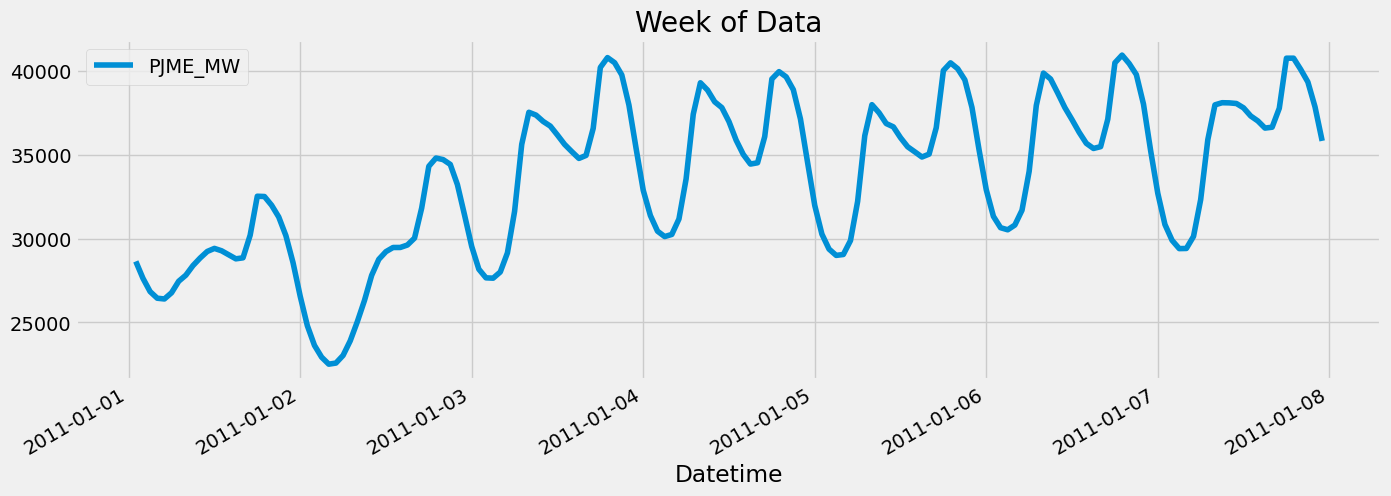

In [23]:
df.loc[(df.index > '01-01-2011') & (df.index < '01-08-2011')] \
.plot(figsize=(15, 5), title='Week of Data');

### Feature Creation

In [24]:
def create_features(df):
    """
    Create time series features based on time series index. 
    """
    df.copy()
    df['Hour'] = df.index.hour
    df['Day_of_Week'] = df.index.dayofweek
    df['Quarter'] = df.index.quarter
    df['Month'] =  df.index.month
    df['Year'] = df.index.year
    df['Day_of_Year'] = df.index.dayofyear
    return df

In [25]:
df = create_features(df)

In [26]:
df

,PJME_MW,Hour,Day_of_Week,Quarter,Month,Year,Day_of_Year
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1


in 'day_of_week' Monday is 0 and Sunday is 6

## Visualize relationship features/Target 

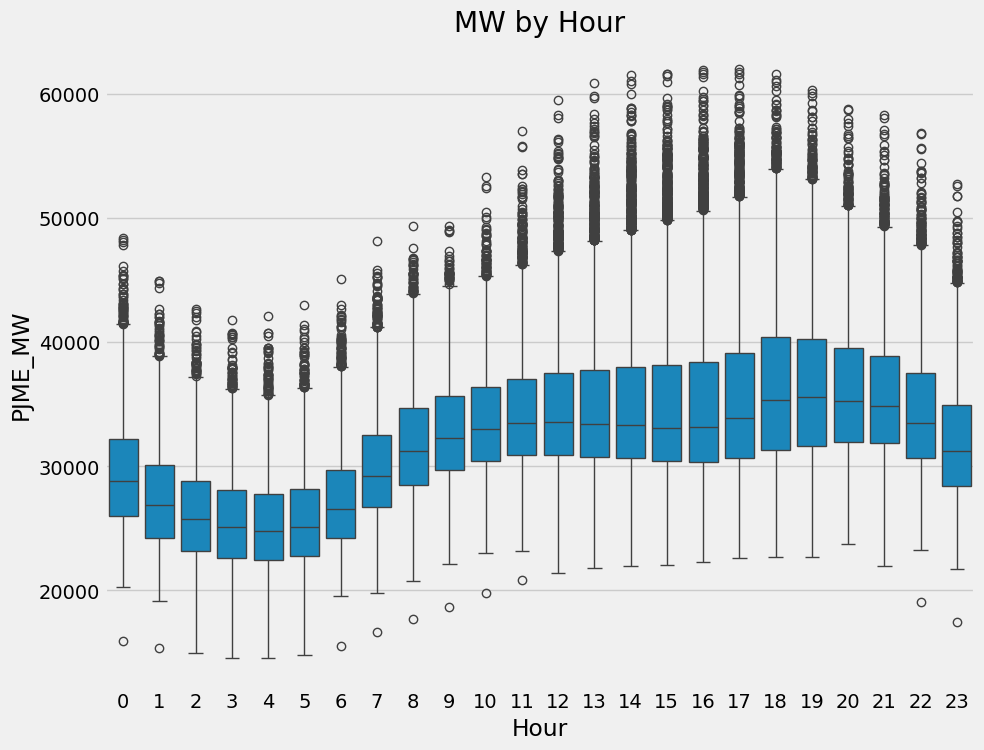

In [27]:
fig, ax= plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Hour', y='PJME_MW')
ax.set_title('MW by Hour');

The box plot shows that early in the mornign, there is a deep in a consumption of energy used, where the consumption picks up from 6am

C:\Users\enaba\AppData\Local\Temp\ipykernel_5232\1518418144.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Month', y='PJME_MW', palette='Blues')


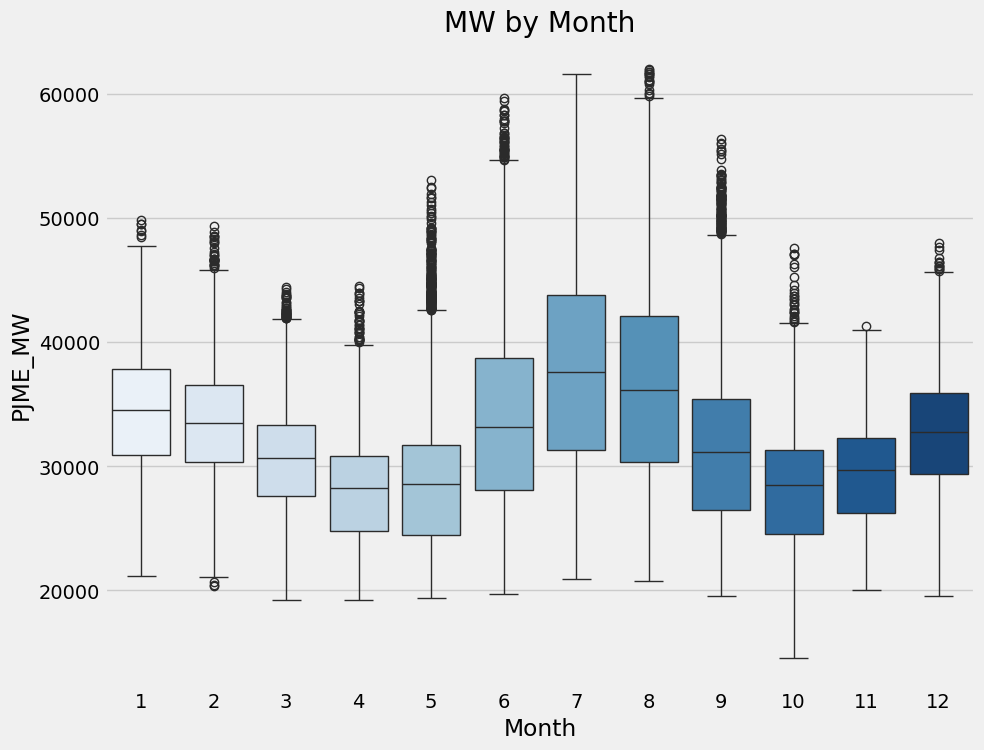

In [28]:
fig, ax= plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month');

The peak month tends to be in summer season and specifically in July, where i assume is due to the fact that more ACs are operating

## Model Creation

In [29]:
###run the train and test sets through create fetures function
train = create_features(train)
test = create_features(test)


### Define the features
FEATURES = ['Hour', 'Day_of_Week', 'Quarter', 'Month', 'Year','Day_of_Year']
TARGET = 'PJME_MW'

C:\Users\enaba\AppData\Local\Temp\ipykernel_5232\2046552965.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df.index.hour
C:\Users\enaba\AppData\Local\Temp\ipykernel_5232\2046552965.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day_of_Week'] = df.index.dayofweek
C:\Users\enaba\AppData\Local\Temp\ipykernel_5232\2046552965.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [30]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [31]:
reg = xgb.XGBRegressor(n_estimators = 1000, 
                       early_Stopping_rounds=50, 
                       learning_rate = 0.01)

reg.fit(X_train, y_train,
       eval_set = [(X_train, y_train), (X_test, y_test)],
       verbose = True)

c:\Users\enaba\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [23:17:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "early_Stopping_rounds" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[1]	validation_0-rmse:6363.01592	validation_1-rmse:6438.46762
[2]	validation_0-rmse:6319.31204	validation_1-rmse:6397.84624
[3]	validation_0-rmse:6276.10095	validation_1-rmse:6358.15224
[4]	validation_0-rmse:6233.47267	validation_1-rmse:6319.19260
[5]	validation_0-rmse:6191.44103	validation_1-rmse:6281.02309
[6]	validation_0-rmse:6149.92226	validation_1-rmse:6243.13500
[7]	validation_0-rmse:6109.00344	validation_1-rmse:6206.10246
[8]	validation_0-rmse:6068.55090	validation_1-rmse:6168.76078
[9]	validation_0-rmse:6028.63852	validation_1-rmse:6132.63405
[10]	validation_0-rmse:5989.31481	validation_1-rmse:6096.99961
[11]	validation_0-rmse:5950.47167	validation_1-rmse:6061.95679
[12]	validation_0-rmse:5911.75590	validation_1-rmse:6027.04791
[13]	validation_0-rmse:5873.58600	validation_1-rmse:5992.93845
[14]	validation_0-rmse:5835.89024	validation_1-rmse:5959.05318
[15]	validation_0-rmse:5799.03022	validation_1-rmse:5926.17692
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_Stopping_rounds=50,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

## Feature Importance

the important values on how much the features werre used in each of the trees in the model

In [32]:
reg.feature_importances_

array([0.44760033, 0.11695988, 0.04130848, 0.23337609, 0.02923435,
       0.13152081], dtype=float32)

### create a dataframe on these features

In [33]:
FI = pd.DataFrame(data = reg.feature_importances_,
            index = reg.feature_names_in_,
            columns=['importance'])

In [34]:
FI

,importance
Hour,0.447600
Day_of_Week,0.116960
Quarter,0.041308
Month,0.233376
Year,0.029234
Day_of_Year,0.131521


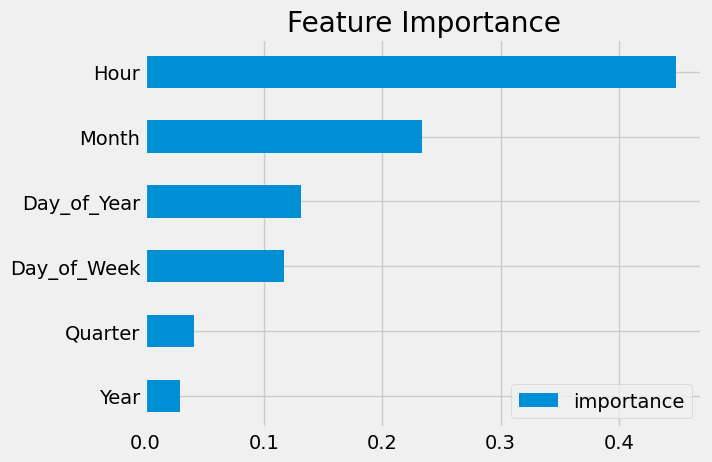

In [35]:
FI.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance');

## Forecast on Test Set

In [36]:
test['predictions'] = reg.predict(X_test)

C:\Users\enaba\AppData\Local\Temp\ipykernel_5232\118111341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = reg.predict(X_test)


### Merge the test set predictions with the original dataframe

In [37]:
df = df.merge(test[['predictions']], how = 'left', left_index = True, right_index = True)

In [38]:
df

,PJME_MW,Hour,Day_of_Week,Quarter,Month,Year,Day_of_Year,predictions
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,39729.453125
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,38733.539062
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,37675.617188


### Plot the new dataframe

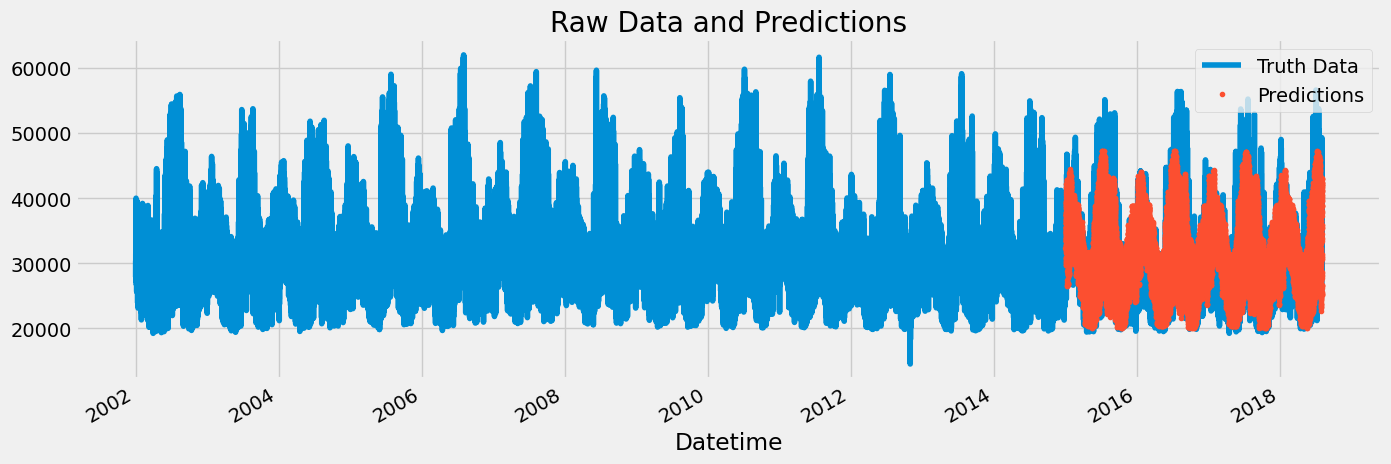

In [39]:
ax = df[['PJME_MW']].plot(figsize = (15,5))
df['predictions'].plot(ax = ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

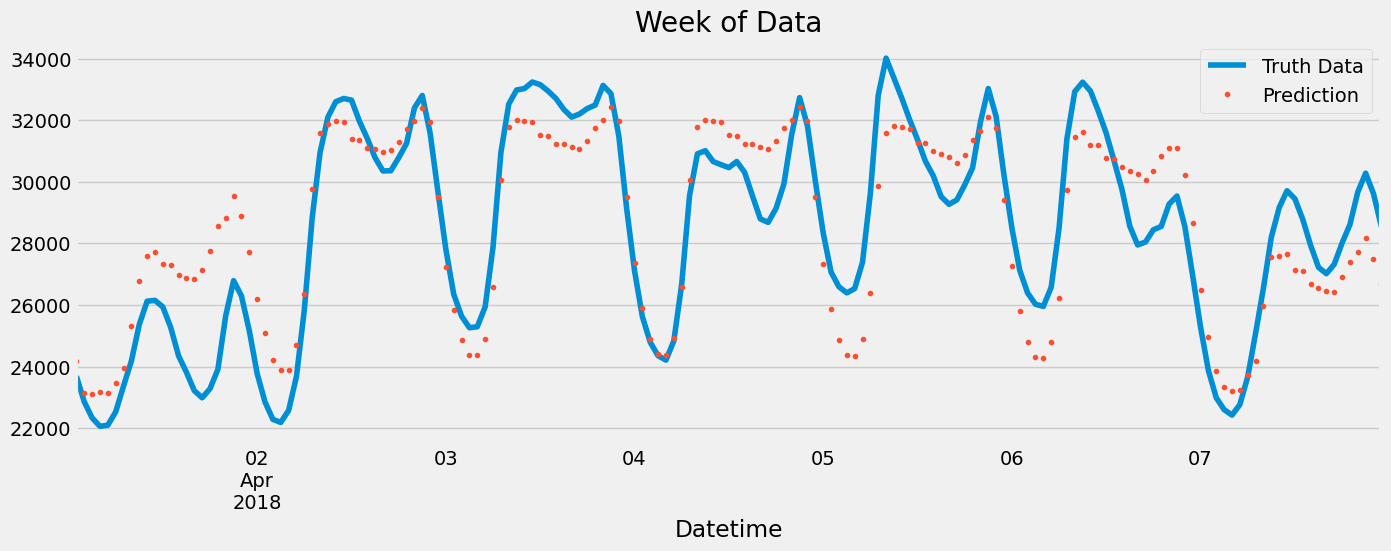

In [40]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['predictions'] \
    .plot(style = '.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()


It looks as our model has predicted the trend but overall it didn't predict well. A better parameter tunning can imporve the prediction. 

We can also add more feature for specific days of the year such as holidays and weekends.
Another feature to add is the weather forcast

### Evaluation Metric

In [41]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['predictions']))
print(f'RMSE score on the test set: {score:0.2f}')

RMSE score on the test set: 3958.84


### Calculate Error

### Which days were the worst days in our predictions

In [42]:
test['error'] = np.abs(test[TARGET] - test['predictions'])

C:\Users\enaba\AppData\Local\Temp\ipykernel_5232\897742453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['error'] = np.abs(test[TARGET] - test['predictions'])


In [43]:
test['date'] = test.index.date

C:\Users\enaba\AppData\Local\Temp\ipykernel_5232\2096088089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = test.index.date


In [44]:
test.groupby('date')['error'].mean().sort_values(ascending = False).head()

date
2016-08-13    16512.169678
2016-08-14    16438.347412
2016-08-12    12419.644613
2016-09-10    11107.929525
2016-09-09    10801.659017
Name: error, dtype: float64

### Which days were the best days in our predictions

In [45]:
test.groupby('date')['error'].mean().sort_values(ascending = True).head()

date
2016-10-02    336.545573
2015-10-28    340.288330
2018-05-06    386.995687
2016-05-06    399.323324
2016-10-08    415.290853
Name: error, dtype: float64